This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2026.1_tutorials/wallaroo-run-anywhere/inference/publish/edge-unet-brain-segmentation-publish).

## Wallaroo Edge Pipeline Publish for U-Net Computer Vision for Brain Segmentation

The following example uses the [U-Net for brain segmentation model](https://github.com/mateuszbuda/brain-segmentation-pytorch/tree/master) trained to detect lower-grade gliomas to demonstrate how to:

* Deploy the model into a Wallaroo Ops server.
* Perform a sample inferences via the Wallaroo SDK and the API calls.
* Publish the pipeline to an OCI (Open Container Initiative) registry service.
* Deploy the published pipeline to an edge device as a Wallaroo Inference Server, and perform the same inference calls.

Upon completion, the follow up tutorial [U-Net for Brain Segmentation Deployment in Wallaroo](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2026.1_tutorials/wallaroo-run-anywhere/inference/deploy/edge-unet-brain-segmentation-deploy) demonstrates deploying the publish in an edge/multi-cloud environment and performing sample inferences through its endpoints.

### Prerequisites

* A Wallaroo Community Edition or Enterprise Edition server with Edge Deployment enabled.
  * For a free license of Wallaroo Community Edition, go to [https://portal.wallaroo.community/](https://portal.wallaroo.community/).
* A x64 edge device capable of running Docker

### References

* [Edge Deployment Registry Guide](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/)
* [Brain MRI segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation): The original evaluation and training images.  These can be used with this inference server.

## Tutorial Steps

### Import Libraries

The first step is to import the libraries we'll be using.  These are included by default in the Wallaroo instance's JupyterHub service.

Verify that the following Python libraries are installed. The `wallaroo` library is included with the Wallaroo Ops JupyterHub instance.

* `pillow`
* `torchvision`
* `pandas`
* `pyarrow`
* `wallaroo`

* References
  * [Wallaroo SDK Install Guides](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-install-guides/)

In [1]:
import wallaroo
from wallaroo.pipeline   import Pipeline
from wallaroo.deployment_config import DeploymentConfigBuilder
from wallaroo.framework import Framework

# used to convert the Image into a numpy array
from PIL import Image
from torchvision import transforms

import pyarrow as pa
import numpy as np
import pandas as pd

import requests

# used to display dataframe information without truncating
from IPython.display import display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

The option `request_timeout` provides additional time for the Wallaroo model upload process to complete.

In [2]:
wl = wallaroo.Client()

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace names must be unique.  The following helper function will either create a new workspace, or retrieve an existing one with the same name.  Verify that a pre-existing workspace has been shared with the targeted user.

Set the variables `workspace_name` to ensure a unique workspace name if required.

The workspace will then be set as the Current Workspace.  Model uploads and pipeline creation through the SDK are set in the current workspace.

* References
  * [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)

In [3]:
workspace_name = "unet-detection-run-anywhere-demonstration"
model_name = "pt-unet"
model_file_name = './models/unet.pt'
pipeline_name = "pt-unet"

workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)
wl.set_current_workspace(workspace)

{'name': 'unet-detection-run-anywhere-demonstration', 'id': 1670, 'archived': False, 'created_by': 'john.hummel@wallaroo.ai', 'created_at': '2025-05-16T16:06:57.419502+00:00', 'models': [{'name': 'pt-unet', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2025, 5, 16, 16, 7, 0, 387130, tzinfo=tzutc()), 'created_at': datetime.datetime(2025, 5, 16, 16, 7, 0, 387130, tzinfo=tzutc())}], 'pipelines': [{'name': 'pt-unet', 'create_time': datetime.datetime(2025, 5, 16, 16, 12, 20, 695563, tzinfo=tzutc()), 'definition': '[]'}]}

### Upload Model

The model is uploaded as a PyTorch model.  This requires the input and output schemas for the model specified in Apache Arrow Schema format.

* References
  * [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: PyTorch](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-upload-pytorch/)

In [4]:
import pyarrow as pa

input_schema = pa.schema([
    pa.field('input', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(),
                list_size=256
            ),
            list_size=256
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('output', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(),
                list_size=256
            ),
            list_size=256
        ),
        list_size=1
    )),
])


In [5]:
modelpath = 'models/unet.pt'

model = wl.upload_model(model_name, 
                        model_file_name, 
                        framework=Framework.PYTORCH, 
                        input_schema=input_schema, 
                        output_schema=output_schema)
model

Waiting for model loading - this will take up to 10min.

Model is pending loading to a native runtime.............................
Model is attempting loading to a native runtime..
Successful
Ready


Name,pt-unet
Version,3cfc89d7-bc64-43d5-afc7-2a2ff618fc6d
File Name,unet.pt
SHA,8824a893cf676a68b97e36d8352cc37a1db7816f01d6afa4467b1806c4527ffa
Status,ready
Image Path,None
Architecture,x86
Acceleration,none
Updated At,2025-11-Jul 19:16:08
Workspace id,1670
Workspace name,unet-detection-run-anywhere-demonstration


In [6]:
model.config().runtime()

'onnx'

### Deploy Pipeline

We create the pipeline with the `wallaroo.client.build_pipeline` method, and assign our model as a model pipeline step.  Once complete, we will deploy the pipeline to allocate resources from the Kuberntes cluster hosting the Wallaroo Ops to the pipeline.

In [7]:
pipeline = wl.build_pipeline(pipeline_name)
pipeline.add_model_step(model)

name,pt-unet
created,2025-05-16 16:12:20.695563+00:00
last_updated,2025-07-11 19:16:11.762212+00:00
deployed,False
workspace_id,1670
workspace_name,unet-detection-run-anywhere-demonstration
arch,x86
accel,none
tags,
versions,"b8eaaf0a-1ec5-4327-ae54-cec4f3d73cf9, e19be4f2-dff6-4561-9783-2b6a359a1e19, 0627e43f-6c8d-4cee-bfd4-e0fb1b4d95d3, bd62f455-d809-4c9c-b881-03d36183c3cb"
steps,pt-unet


Next we configure the hardware we want to use for deployment. If we plan on eventually deploying to edge, this is a good way to simulate edge hardware conditions.

The pipeline is then deployed with our deployment configuration, which allocates cluter resources to the pipeline.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/)

In [8]:
deployment_config = DeploymentConfigBuilder() \
    .cpus(0.25).memory('1Gi') \
    .build()
pipeline.deploy(deployment_config=deployment_config)
pipeline.status()

Waiting for deployment - this will take up to 45s ............. ok


{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.4.1.62',
   'name': 'engine-548bd5bdd-bjw69',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'pt-unet',
      'status': 'Running',
      'version': '06d72494-21c7-4d93-8bb8-0a3e4b4be410'}]},
   'model_statuses': {'models': [{'model_version_id': 814,
      'name': 'pt-unet',
      'sha': '8824a893cf676a68b97e36d8352cc37a1db7816f01d6afa4467b1806c4527ffa',
      'status': 'Running',
      'version': '3cfc89d7-bc64-43d5-afc7-2a2ff618fc6d'}]}}],
 'engine_lbs': [{'ip': '10.4.1.61',
   'name': 'engine-lb-648945b8b4-qwft5',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

### Test Inference

We will perform a test inference by converting the file `TCGA_CS_4944.png` into a numpy array, and setting that as a row in a DataFrame for our inference request.

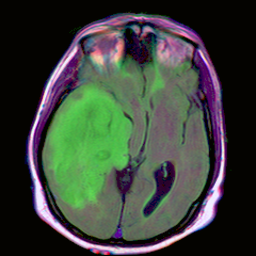

(1, 3, 256, 256)

In [9]:

input_image = Image.open("./data/TCGA_CS_4944.png")
display(input_image)

# preprocess
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

nimage = input_batch.detach().numpy()
nimage.shape

In [10]:
nimage = input_tensor.detach().numpy()

input_data = {
        "input": [nimage]
}
dataframe = pd.DataFrame(input_data)

We can now perform an inference in two ways:

* Wallaroo SDK:  The method `wallaroo.pipeline.infer` accepts a DataFrame or Apache Arrow table and returns an inference result.
* Wallaroo Pipline Inference URL:  Deployed pipelines provide an inference URL that accepts a DataFrame or Apache Arrow table through an API call.

For this demonstration and to save space in the notebook, only the first few elements are shown.

* References
  * [Wallaroo SDK Essentials Guide: Inference Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-inferences/)
  * [Wallaroo MLOps API Essentials Guide: Inference Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-api-guide/wallaroo-mlops-api-essential-guide/wallaroo-mlops-api-essential-guide-inferences/)

In [11]:
# inference via the Wallaroo SDK
result = pipeline.infer(dataframe)
# display(result)
result["out.output"][0:5]

0    [1.475215e-05, 1.463294e-05, 1.3977289e-05, 1.3887882e-05, 1.4543533e-05, 1.4483929e-05, 1.4811754e-05, 1.4811754e-05, 1.5079975e-05, 1.4781952e-05, 1.5079975e-05, 1.5169382e-05, 1.4692545e-05, 1.4811754e-05, 1.5079975e-05, 1.5884638e-05, 1.4781952e-05, 1.6331673e-05, 1.4781952e-05, 1.5109777e-05, 1.4513731e-05, 1.4215708e-05, 1.4901161e-05, 1.6242266e-05, 1.3768673e-05, 1.5467405e-05, 1.4126301e-05, 1.4990568e-05, 1.4364719e-05, 1.4066696e-05, 1.4960766e-05, 1.6510487e-05, 1.4424324e-05, 1.6331673e-05, 1.552701e-05, 1.4960766e-05, 1.4901161e-05, 1.40964985e-05, 1.4692545e-05, 1.463294e-05, 1.6242266e-05, 1.6391277e-05, 1.6510487e-05, 1.4662743e-05, 1.4692545e-05, 1.3977289e-05, 1.4394522e-05, 1.4394522e-05, 1.5974045e-05, 1.591444e-05, 1.5825033e-05, 1.4394522e-05, 1.4424324e-05, 1.4334917e-05, 1.4305115e-05, 1.4066696e-05, 1.5348196e-05, 1.5199184e-05, 1.6063452e-05, 1.4543533e-05, 1.4483929e-05, 1.4036894e-05, 1.4334917e-05, 1.4126301e-05, 1.5377998e-05, 1.5258789e-05, 1.546740

In [12]:
# inference via the Wallaroo Pipeline Inference URL

headers = wl.auth.auth_header()

headers['Content-Type'] = 'application/json; format=pandas-records'

deploy_url = pipeline._deployment._url()

response = requests.post(
                    deploy_url, 
                    headers=headers, 
                    data=dataframe.to_json(orient="records")
                )

display(pd.DataFrame(response.json()).loc[0, 'out']['output'][0:5])

[1.475215e-05, 1.463294e-05, 1.3977289e-05, 1.3887882e-05, 1.4543533e-05]

### Undeploy the Pipeline

With the inference tests complete, we can undeploy the pipeline and return the resources back to the cluster.

In [13]:
pipeline.undeploy()

Waiting for undeployment - this will take up to 45s ................................... ok


name,pt-unet
created,2025-05-16 16:12:20.695563+00:00
last_updated,2025-07-11 19:16:12.003963+00:00
deployed,False
workspace_id,1670
workspace_name,unet-detection-run-anywhere-demonstration
arch,x86
accel,none
tags,
versions,"06d72494-21c7-4d93-8bb8-0a3e4b4be410, b8eaaf0a-1ec5-4327-ae54-cec4f3d73cf9, e19be4f2-dff6-4561-9783-2b6a359a1e19, 0627e43f-6c8d-4cee-bfd4-e0fb1b4d95d3, bd62f455-d809-4c9c-b881-03d36183c3cb"
steps,pt-unet


### Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)`.

### Publish Example

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command. 

In [14]:
# edge deployment

pub = pipeline.publish()
pub

Waiting for pipeline publish... It may take up to 600 sec.
...... Published.shing.


ID,84
Pipeline Name,pt-unet
Pipeline Version,d8a794ad-ab60-4c97-9a3e-a18cf7d8bc17
Status,Published
Workspace Id,1670
Workspace Name,unet-detection-run-anywhere-demonstration
Edges,
Engine URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2025.1.0-6245
Pipeline URL,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/pt-unet:d8a794ad-ab60-4c97-9a3e-a18cf7d8bc17
Helm Chart URL,oci://us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts/pt-unet
Helm Chart Reference,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/charts@sha256:2dc39fddbeffe2ea73b479a5a4dc06921987aa6fa92d56184b93117c912e0f78


Upon completion, the follow up tutorial [U-Net for Brain Segmentation Deployment in Wallaroo](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2026.1_tutorials/wallaroo-run-anywhere/inference/deploy/edge-unet-brain-segmentation-deploy) demonstrates deploying the publish in an edge/multi-cloud environment and performing sample inferences through its endpoints.